In [11]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import os
%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

plt.style.use(machine_path+'/opt/scripts/des.mplstyle')

In [12]:
##############################################################################
# Plot a data: domain, velocity field and rheology
##############################################################################

# total model horizontal extent (m)
Lx = 1600 * 1.0e3

# total model vertical extent (m)
Lz = 700 * 1.0e3

# number of points in horizontal direction
Nx = 401

# number of points in vertical direction
Nz = 71

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3

# thickness of lower crust (m)
thickness_lower_crust = 15 * 1.0e3

# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3

# total thickness of lithosphere (m)
thickness_litho = 120 * 1.0e3#130 * 1.0e3

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)
dz = Lz / (Nz - 1)

# ##############################################################################
# # Thermal profiles
# ##############################################################################

z = np.linspace(Lz, 0, Nz)
dz = Lz / (Nz - 1)

# DTS = [0, 100, 200]
# DTS = [200, 290, 350]
DTS = [230]
Tzs = []

Huc = 2.5e-6 / 2700.0 #9.259E-10
Hlc = 0.8e-6 / 2800.0 #2.85E-10

for DT in DTS:
    T = 1300 * (z - thickness_sa) / (thickness_litho)  # Temperature

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K?

    TP = 1262 #mantle potential temperature

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)) + DT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 

    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(T)

    cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa)  # upper crust
    H[cond] = Huc

    cond = (z >= thickness_upper_crust + thickness_sa) & (
        z < thickness_lower_crust + thickness_upper_crust + thickness_sa
    )  # lower crust
    H[cond] = Hlc

    Taux = np.copy(T)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    cond = cond1 | (T == 0)  # (T > 1300) | (T == 0) #VICTOR
    dz = Lz / (Nz - 1)

    
    while t < 500.0e6:
        T[1:-1] += (
            kappa * dt_sec * ((T[2:] + T[:-2] - 2 * T[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T[cond] = Taux[cond]
        t = t + dt
    
    T = np.ones_like(X) * T[:, None] #(Nz, Nx)

    Tz = np.copy(T)
    Tzs.append(Tz)
##############################################################################################################################
# YSE data

def calc_YSE(ax, T_mean_region, z,
                      clc = 10,
                      thickness_sa = 40 * 1.0e3,
                      thickness_upper_crust = 20 * 1.0e3,
                      thickness_lower_crust = 15 * 1.0e3,
                      thickness_litho = 80 * 1.0e3,
                      plot=True):
###################################################################################
    # Creating YSE

    L = thickness_litho #select from z axis of the scenario
    N = int(2*thickness_litho/1.0e3 + 1)
    z_yse = np.linspace(0, L, N)
    dz_yse = z_yse[1]-z_yse[0]

    f = interp1d(z, T_mean_region)
    T_interp = f(z_yse/1.0e3)

    rho = np.zeros_like(z_yse)

    #conditions for regions
    uc = (z_yse <= thickness_upper_crust)
    lc = (z_yse > thickness_upper_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust)
    lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    # if(mobile_belt):
    #     lm = (z_yse > thickness_upper_crust + thickness_lower_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust + 30.0e3)
    #     mb = (z_yse > thickness_upper_crust + thickness_lower_crust + 30.0e3)
    # else:
    #     lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    rho[uc]=2700.0
    rho[lc]=2800.0
    rho[lm]=3354.0
    g = 10.0

    P = 0.0
    Paux = 0.0
    for i in range(1, N):
        Paux += dz_yse*rho[i]*g
        P = np.append(P, Paux)

    phi = 2.0*np.pi/180.0
    c0 = 4.0E6
    sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

    phi = 15.0*np.pi/180.0
    c0 = 20.0E6
    sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

    #rheological params
    Q = np.zeros_like(z_yse)
    A = np.zeros_like(z_yse)
    n = np.zeros_like(z_yse)
    V = np.zeros_like(z_yse)
    C = np.zeros_like(z_yse)

    Q[uc]=222000.0
    Q[lc]=222000.0
    Q[lm]=540000.0

    A[uc]=8.574E-28
    A[lc]=8.574E-28
    A[lm]=2.4168E-15

    n[uc]=4.0
    n[lc]=4.0
    n[lm]=3.5

    V[uc]=0.0
    V[lc]=0.0
    V[lm]=25.0E-6

    #strain rate (sr)
    sr = 1.0E-15

    #gas constant
    R = 8.314

    #print(n)

    #Temperature Kelvin
    TK = T_interp + 273

    #Viscosity
    #Choosing C for layers
    C[uc]=1.0
    C[lc] = clc
    C[lm]=1.0
    
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]

    # if(plot==True):
    #     plot_YSE(ax, sigma_v, z_yse, thickness_sa, thickness_upper_crust, thickness_lower_crust, thickness_litho,)

    return sigma_v, z_yse

def plot_YSE(ax, sigma_v, z_yse, thickness_sa = 40 * 1.0e3,
                      thickness_upper_crust = 20 * 1.0e3,
                      thickness_lower_crust = 15 * 1.0e3,
                      thickness_litho = 120 * 1.0e3,
                      color='xkcd:red',
                      linestyle='-',
                      fill=False, label=None):
    

    uc = (z_yse <= thickness_upper_crust)
    lc = (z_yse > thickness_upper_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust)
    lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    ax.plot(sigma_v/1.0E9, z_yse/1000, linestyle=linestyle, color=color, alpha=0.7, label=label)

    cr = 255.
    color_uc = (228./cr, 156./cr, 124./cr)
    color_lc = (240./cr, 209./cr, 188./cr)
    color_lit = (155./cr, 194./cr, 155./cr)
    color_ast = (207./cr, 226./cr, 205./cr)

    if(fill==True):
        #filling inside YSE
        ax.fill_betweenx(z_yse[uc]/1000, z_yse[uc]*0, sigma_v[uc]/1.0E9, color=color_uc, ec=color)
        ax.fill_betweenx(z_yse[lc]/1000, z_yse[lc]*0, sigma_v[lc]/1.0E9, color=color_lc, ec=color)
        ax.fill_betweenx(z_yse[lm]/1000, z_yse[lm]*0, sigma_v[lm]/1.0E9, color=color_lit, ec=color)

##############################################################################################################################


#Rifting plots
# total model horizontal extent (m)
Lx = 1600 * 1.0e3
# total model vertical extent (m)
Lz = 400 * 1.0e3
# number of points in horizontal direction
Nx = 1601
# number of points in vertical direction
Nz = 401

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)
dz = Lz / (Nz - 1)

#velocity field
velocity = 1.0 #cm/yr     
fac_air = 10.0e3
#1.0 cm/yr
# vL = 0.005 / (365 * 24 * 3600)  # m/s

# 0.5 cm/year
# vL = 0.0025 / (365 * 24 * 3600)  # m/s

# 0.25 cm/year
# vL = 0.00125 / (365 * 24 * 3600)  # m/s

vL = (0.5*velocity/100) / (365 * 24 * 3600)  # m/s

h_v_const = thickness_litho + 20.0e3  #thickness with constant velocity 
ha = Lz - thickness_sa - h_v_const  # difference

vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

VX = np.zeros_like(X)
cond = (Z > h_v_const + thickness_sa) & (X == 0)
VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

cond = (Z > h_v_const + thickness_sa) & (X == Lx)
VX[cond] = -vR * (Z[cond] - h_v_const - thickness_sa) / ha

cond = X == Lx
VX[cond] += +2 * vL

cond = Z <=  40.0e3#thickness_sa - fac_air
VX[cond] = 0

# print(np.sum(VX))

v0 = VX[(X == 0)]
vf = VX[(X == Lx)]
sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
# print(sv0, svf, svf - sv0)

diff = (svf - sv0) * dz

vv = -diff / Lx
# print(vv, diff, svf, sv0, dz, Lx)

VZ = np.zeros_like(X)

cond = Z == 0
VZ[cond] = vv
#save bc to plot arraows in numerical setup
vels_bc = np.array([v0, vf])
vz0 = VZ[(z == 0)]


# Article new

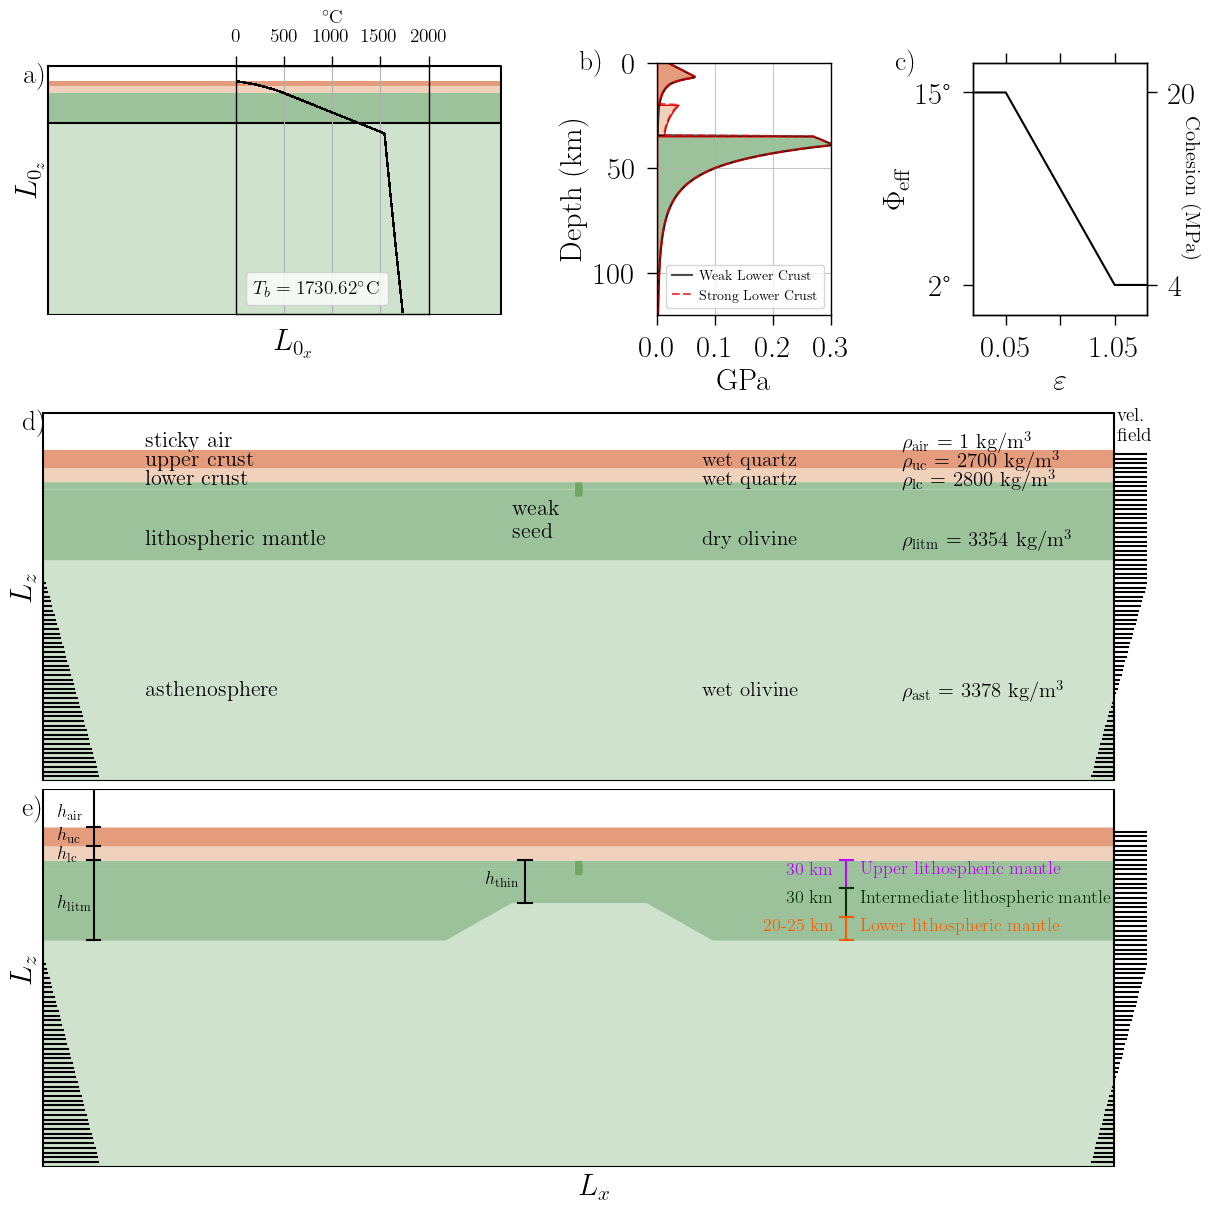

In [35]:
plt.close()
fig = plt.figure(figsize=(12,12), constrained_layout=True)
mosaic = """
         AABC
         DDDD
         EEEE
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.3,0.45,0.45]})
fsize=16

fsize=16

#layers colour scheme
cr = 255.
color_uc = (228./cr,156./cr,124./cr)
color_lc = (240./cr,209./cr,188./cr)
color_lit = (155./cr,194./cr,155./cr)
color_ast = (207./cr,226./cr,205./cr)

##############################################################################
# Subplot a) Stability
##############################################################################
scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

# thickness of upper crust (m)
thickness_upper_crust = 15.0e3*scale 

# thickness of lower crust (m)
thickness_lower_crust = 20.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 120.0e3*scale #130 * 1.0e3

Lx_stab = 1600 * 1.0e3
Lz_stab = 700 * 1.0e3

Nx_stab = 161
Nz_stab = 71

x_stab = np.linspace(0, Lx_stab, Nx_stab)
z_stab = np.linspace(Lz_stab, 0, Nz_stab)
X_stab, Z_stab = np.meshgrid(x_stab, z_stab)
dz_stab = Lz_stab/ (Nz_stab - 1)

# Interfaces (bottom first)
interfaces_stab = {
    "litho": np.ones(Nx_stab) * (thickness_litho + thickness_sa), #lab horizontal
    "lower_crust": np.ones(Nx_stab) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx_stab) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx_stab) * (thickness_sa),
    }

axs['A'].text(-0.02, 0.95, 'a)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs['A'].transAxes)

axs['A'].set_xlim(0 - 50, Lx_stab/1000 + 50)
axs['A'].set_ylim(-Lz_stab/1000, 10)
axs['A'].axis('off')

#box domain contour
axs['A'].plot([0,0,Lx_stab/1000,Lx_stab/1000,0],[0,-Lz_stab/1000,-Lz_stab/1000,0,0],"k")

#paint layers
a1_stab = interfaces_stab["litho"]
a2_stab = a1_stab*0+700.0E3

axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_ast,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["lower_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lit,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab = interfaces_stab["upper_crust"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_lc,ec="face",lw=0.0)

a2_stab = np.copy(a1_stab)
a1_stab= interfaces_stab["air"]
axs['A'].fill_between(x_stab/1000,-a1_stab/1000,-a2_stab/1000,fc=color_uc,ec="face",lw=0.0)

axs['A'].plot([0, Lx_stab/1000], [-160, -160], "k") #horizontal bar

#Lz and Lx
axs['A'].text(-115, -350, r"$L_{0_z}$",rotation=90, fontsize=fsize+6)
axs['A'].text(Lx_stab/2.0e3, -Lz_stab/1000-100, r"$L_{0_x}$", fontsize=fsize+6)

# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)

ax_aux = axs['A'].inset_axes([0.42,
                              0.001,
                              0.40,
                              0.985])

ax_aux.get_yaxis().set_visible(False)
ax_aux.set_xlabel('$^{\circ}$C', fontsize=label_size-4)
ax_aux.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, labelsize=label_size-4)
ax_aux.xaxis.set_label_position('top')
ax_aux.set_facecolor("none")
ax_aux.xaxis.grid('-k', alpha=1)

ax_aux.set_xlim([0,2000])
ax_aux.set_xticks([0, 500, 1000, 1500, 2000])
ax_aux.set_ylim(-Lz_stab/1000, 10)

z_stab = np.linspace(Lz_stab, 0, Nz_stab)*scale
cT = z_stab>=40.0e3*scale

colors = ['xkcd:black']
lines = ['-']

for Tz, color, line in zip(Tzs, colors, lines):
    ax_aux.plot(Tz[cT], -(z_stab[cT]/1000)+8, line, color=color, linewidth=1, alpha=0.8)

axt = ax_aux.twinx()
axt1 = ax_aux.twinx()
axt.axis('off')
axt1.axis('off')

axt1.plot([-10, -10], '-', color=colors[0], label=r'$T_{b} = 1730.62^{\circ}$C')

axt1.legend(loc='lower left', labelcolor=colors[0], handlelength=0, handletextpad=0, fontsize=14)

##############################################################################
# Subplot b) Rheology
##############################################################################

scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale

# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 

# thickness of lower crust (m)
thickness_lower_crust = 15.0e3*scale 

# total thickness of lithosphere (m)
thickness_litho = 120.0e3*scale #130 * 1.0e3


# total model vertical extent (m)
Lz = 400 * 1.0e3
# number of points in vertical direction
Nz = 401
filename = 'input_temperature_0.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))
temper_0 = temper_0[:,0] #profile at idx=0
z = np.linspace(Lz/1000, 0, Nz)
thickness_sa = 40.0e3
z_YSE = z - thickness_sa/1.0e3


Lz_yse = 400.0e3
Nz_yse = 401
z_yse = np.linspace(Lz_yse/1000, 0, Nz_yse)
z_yse = z_yse - 40.0
cond_yse = z_yse>=0

ax_letter = 'B'
sigma_v, z_yse_plot = calc_YSE(axs[ax_letter], temper_0[cond_yse], z_yse[cond_yse], thickness_litho=120.03e3, clc=1)
plot_YSE(axs[ax_letter], sigma_v, z_yse_plot, thickness_sa, thickness_upper_crust, thickness_lower_crust, thickness_litho=120.03e3, color='xkcd:black', linestyle='-', fill=False, label='Weak Lower Crust')
sigma_v, z_yse_plot = calc_YSE(axs[ax_letter], temper_0[cond_yse], z_yse[cond_yse], thickness_litho=120.03e3, clc=10)
plot_YSE(axs[ax_letter], sigma_v, z_yse_plot, thickness_sa, thickness_upper_crust, thickness_lower_crust, thickness_litho=120.03e3, color='xkcd:red', linestyle='--', fill=True, label='Strong Lower Crust')

label_size=22
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)
axs[ax_letter].text(-0.45, 1, 'b)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[ax_letter].transAxes)
axs[ax_letter].set_xlim(0, 0.3)
axs[ax_letter].set_xticks([0, 0.1, 0.2, 0.3,])
axs[ax_letter].set_ylim(120, 0)
axs[ax_letter].set_xlabel("GPa", fontsize=label_size)
axs[ax_letter].set_ylabel("Depth (km)", fontsize=label_size)
axs[ax_letter].grid('-k', alpha=0.7)
# axs[ax_letter].plot([-10, -10], [-10, -10], '-', color='xkcd:black', label='Weak Lower Crust')
# axs[ax_letter].plot([-10, -10], [-10, -10], '--', color='xkcd:red', label='Strong Lower Crust')
axs[ax_letter].legend(loc='lower right', fontsize=10, handlelength=1.5, handletextpad=0.5)

##############################################################################
#Subplot c) Effective friction
##############################################################################
ax_letter = 'C'
axs[ax_letter].text(-0.45, 1, 'c)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[ax_letter].transAxes)

# xdata = np.array([0, 0.05, 1.05, 1.1])
xdata = np.array([0, 0.25, 0.75, 1.0])
ydata = np.array([15, 15, 2, 2])

axs[ax_letter].plot(xdata, ydata, 'k-')

axs[ax_letter].set_xlim([0.10, 0.9])
axs[ax_letter].set_ylim([0, 17])
axs[ax_letter].set_xticks([0.25, 0.5, 0.75])
axs[ax_letter].set_xticklabels([0.05, ' ', 1.05])
axs[ax_letter].tick_params('x', top=True, labeltop=False)
axs[ax_letter].set_xlabel(r"$\varepsilon$", fontsize=label_size)

axs[ax_letter].set_yticks([2, 15])
axs[ax_letter].set_yticklabels(['2°', '15°'])
axs[ax_letter].set_ylabel('$\Phi_{\mathrm{eff}}$', fontsize=label_size)

axsCt = axs[ax_letter].twinx()
axsCt.set_ylim([0, 17])
axsCt.set_yticks([2, 15])
axsCt.set_yticklabels([4, 20])
axsCt.set_ylabel('Cohesion (MPa)', fontsize=label_size-7, rotation=270)


##############################################################################
# Subplot d) interfaces,  Layers, veloc field
##############################################################################

scale = 1.0
# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3*scale
thickness_lower_crust = 15.0e3*scale 
# thickness of upper crust (m)
thickness_upper_crust = 20.0e3*scale 
# total thickness of lithosphere (m)
thickness_litho = 120.0e3*scale #130 * 1.0e3

# Interfaces (bottom first)
seed_depth = 8 * 1.0e3*scale #9 * 1.0e3 #original
thickness_seed = 16 * 1.0e3*scale
x_seed = Lx / 2.0
n_seed = 12

interfaces = {
            "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
            "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
            "air": np.ones(Nx) * (thickness_sa),
        }

interfaces["seed_base"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ] = (
            interfaces["seed_base"][
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            + thickness_seed // 2
        )

interfaces["seed_top"][
            int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
        ] = (
            interfaces["seed_top"][
                int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
            ]
            - thickness_seed // 2
        )

interfaces_ramp = {
            "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
            "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
            "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
            "air": np.ones(Nx) * (thickness_sa),
        }

interfaces_ramp["seed_base"] = interfaces["seed_base"]
interfaces_ramp["seed_top"] = interfaces["seed_top"]

xcenter = Lx / 2.0
dx = Lx / (Nx - 1)

#central part - must thin to 80 km
central_begin = xcenter - 100.0e3
central_end = xcenter + 100.0e3
Lcentral = central_end - central_begin
Ncentral = int(Lcentral//dx)
thinning = 40.0e3
interfaces_ramp["litho"][Nx//2 - Ncentral//2 : Nx//2 + Ncentral//2] = thickness_sa + thickness_litho - thinning

#building the ramp of letf side
xrampl_begin = xcenter - 200.0e3
xrampl_end = xrampl_begin + 100.0e3

idxl = np.where(x == xrampl_begin)[0][0]
idxr = np.where(x == xrampl_end)[0][0]

yrampl_begin = thickness_sa + thickness_litho
yrampl_end = thickness_sa + thickness_litho - thinning

ramp_slope = (yrampl_end - yrampl_begin) / (xrampl_end - xrampl_begin)
for i in range(idxl, idxr):
    interfaces_ramp["litho"][i] = yrampl_begin + ramp_slope * (x[i] - xrampl_begin)

#building the ramp of right side
xrampr_begin = xcenter + 100.0e3
xrampr_end = xrampr_begin + 100.0e3

idxl = np.where(x == xrampr_begin)[0][0]
idxr = np.where(x == xrampr_end)[0][0]

yrampr_begin = thickness_sa + thickness_litho - thinning
yrampr_end = thickness_sa + thickness_litho

ramp_slope = (yrampr_end - yrampr_begin) / (xrampr_end - xrampr_begin)
for i in range(idxl, idxr):
    interfaces_ramp["litho"][i] = yrampr_begin + ramp_slope * (x[i] - xrampr_begin)

ax_letter = 'D'
axs[ax_letter].text(-0.01, 0.95, 'd)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[ax_letter].transAxes)

axs[ax_letter].set_xlim(0 - 15, Lx/1000 + 50)
axs[ax_letter].set_ylim(-Lz/1000, 10)
axs[ax_letter].axis('off')

#box domain contour
axs[ax_letter].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces["litho"] #upper
a2 = a1*0 + Lz #lower
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["seed_base"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["seed_top"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:dull green',ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["lower_crust"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["upper_crust"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces["air"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

#Naming layers
fsize=16
xpos = 0.10
yair = 0.9
yuc = 0.85
ylc = 0.80
ylit = 0.64
yast = 0.24

axs[ax_letter].text(xpos, yair, "sticky air", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, yuc, "upper crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylc, "lower crust", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylit, "lithospheric mantle", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, yast, "asthenosphere", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(0.43, 0.69, "weak\nseed", fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)

#Rheology
fsize=15
xpos = 0.6
axs[ax_letter].text(xpos, yuc, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylc, 'wet quartz', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylit, 'dry olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, yast, 'wet olivine', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)

#Layers densities
fsize=15
xpos=0.78
axs[ax_letter].text(xpos, yair, r'$\rho_{\mathrm{air}}$ = 1 kg/m$^3$', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, yuc, r'$\rho_{\mathrm{uc}}$ = 2700 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylc, r'$\rho_{\mathrm{lc}}$ = 2800 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, ylit, r'$\rho_{\mathrm{litm}}$ = 3354 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)
axs[ax_letter].text(xpos, yast, r'$\rho_{\mathrm{ast}}$ = 3378 kg/m$^3$', color='k', fontsize=fsize,
              horizontalalignment='left', verticalalignment='center',
              transform=axs[ax_letter].transAxes)

#Lz and Lx
fsize=22
axs[ax_letter].text(-50, -200, r"$L_z$",rotation=90, fontsize=fsize)
# axs['C'].text(Lx/1000/2-100, -Lz/1000-50, r"$L_x$", fontsize=fsize)

axs[ax_letter].text(1605,-30,"vel.\nfield",fontsize=fsize-8)

z = np.linspace(Lz, 0, Nz)
cond = z >= 40.0e3
scale_veloc = 5000*365.*24.*3600.
crt=0
for i in range(0,np.size(z),5):
    if VX[i,0]!=0.0:
        axs[ax_letter].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000-crt,-z[i]/1000-crt],"k")

for i in range(0, np.size(z), 5):
    if(z[i] >= 40.0e3):
        axs[ax_letter].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000-crt,-z[i]/1000-crt],"k")

##############################################################################
# Subplot E) interfaces,  Layers, veloc field
##############################################################################
ax_letter = 'E'
axs[ax_letter].text(-0.01, 0.95, 'e)', color='k', fontsize=20,
        horizontalalignment='left', verticalalignment='center',
        transform=axs[ax_letter].transAxes)

axs[ax_letter].set_xlim(0 - 15, Lx/1000 + 50)
axs[ax_letter].set_ylim(-Lz/1000, 0)
axs[ax_letter].axis('off')

#box domain contour
axs[ax_letter].plot([0,0,Lx/1000,Lx/1000,0],[0,-Lz/1000,-Lz/1000,0,0],"k")

#paint layers
a1 = interfaces_ramp["litho"] #upper
a2 = a1*0 + Lz #lower
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_ast,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces_ramp["seed_base"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces_ramp["seed_top"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc='xkcd:dull green',ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces_ramp["lower_crust"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lit,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces_ramp["upper_crust"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_lc,ec="face",lw=0.0)

a2 = np.copy(a1)
a1 = interfaces_ramp["air"]
axs[ax_letter].fill_between(x/1000,-a1/1000,-a2/1000,fc=color_uc,ec="face",lw=0.0)

xpos = 75
axs[ax_letter].plot([xpos, xpos], [-0*scale,-160*scale], "k") #vertical bar
axs[ax_letter].plot([xpos-10, xpos+10], [0*scale, 0*scale], "k") #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-40*scale, -40*scale], "k") #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-60*scale, -60*scale], "k") #base of upper crust
axs[ax_letter].plot([xpos-10, xpos+10], [-75*scale, -75*scale], "k") #base of lower crust
axs[ax_letter].plot([xpos-10, xpos+10], [-160*scale, -160*scale], "k") #base of litho

fsize = 15
xpos = 720
axs[ax_letter].plot([xpos, xpos], [-75*scale,-120*scale], "k") #vertical bar
axs[ax_letter].plot([xpos-10, xpos+10], [-75*scale, -75*scale], "k") #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-120*scale, -120*scale], "k") #base of litho
axs[ax_letter].text(xpos-60, -100*scale, r"$h_{\mathrm{thin}}$", fontsize=fsize-2)

xpos = 20

axs[ax_letter].text(xpos, -30*scale, r"$h_{\mathrm{air}}$", fontsize=fsize-2)
axs[ax_letter].text(xpos, -54*scale, r"$h_{\mathrm{uc}}$", fontsize=fsize-2)
axs[ax_letter].text(xpos, -74*scale, r"$h_{\mathrm{lc}}$", fontsize=fsize-2)
axs[ax_letter].text(xpos, -125*scale, r"$h_{\mathrm{litm}}$", fontsize=fsize-2)


z = np.linspace(Lz, 0, Nz)
scale_veloc = 5000*365.*24.*3600.
crt=0
for i in range(0,np.size(z),5):
    if VX[i,0]!=0.0:
        axs[ax_letter].plot([scale_veloc*VX[i, 0],0], [-z[i]/1000-crt,-z[i]/1000-crt],"k")

for i in range(0,np.size(z), 5):
    if(z[i] >= 40.0e3):
        axs[ax_letter].plot([scale_veloc*VX[i, -1]+Lx/1000,Lx/1000], [-z[i]/1000-crt,-z[i]/1000-crt],"k")
#Lz and Lx
fsize=22
axs[ax_letter].text(-50, -200, r"$L_z$",rotation=90, fontsize=fsize)
axs[ax_letter].text(Lx/1000/2-0, -Lz/1000-30, r"$L_x$", fontsize=fsize)


############################
# Mantleic Regions
##############################
color_mlit_upper='xkcd:bright purple'#'xkcd:cerulean blue'
color_mlit_intermediate='xkcd:dark green'#'xkcd:scarlet'
color_mlit_lower='xkcd:bright orange'#'xkcd:dark green'

fsize = 15
xpos = 1200
#Upper mantle lithosphere
axs[ax_letter].plot([xpos, xpos], [-75*scale,-105*scale], color=color_mlit_upper) #vertical bar
axs[ax_letter].plot([xpos-10, xpos+10], [-75*scale, -75*scale], color=color_mlit_upper) #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-105*scale, -105*scale], color=color_mlit_upper) #base of litho
axs[ax_letter].text(xpos+20, -90*scale, r"Upper lithospheric mantle", fontsize=fsize-2, color=color_mlit_upper)
axs[ax_letter].text(xpos-90, -90*scale, r"30 km", fontsize=fsize-2, color=color_mlit_upper)
#Intermediate mantle lithosphere
xpos = 1200
axs[ax_letter].plot([xpos, xpos], [-105*scale,-135*scale], color=color_mlit_intermediate) #vertical bar
axs[ax_letter].plot([xpos-10, xpos+10], [-105*scale, -105*scale], color=color_mlit_intermediate) #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-135*scale, -135*scale], color=color_mlit_intermediate) #base of litho
axs[ax_letter].text(xpos+20, -120*scale, r"Intermediate lithospheric mantle", fontsize=fsize-2, color=color_mlit_intermediate)
axs[ax_letter].text(xpos-90, -120*scale, r"30 km", fontsize=fsize-2, color=color_mlit_intermediate)

#Lower mantle lithosphere
xpos = 1200
axs[ax_letter].plot([xpos, xpos], [-135*scale,-160*scale], color=color_mlit_lower) #vertical bar
axs[ax_letter].plot([xpos-10, xpos+10], [-135*scale, -135*scale], color=color_mlit_lower) #upper horizontal bar
axs[ax_letter].plot([xpos-10, xpos+10], [-160*scale, -160*scale], color=color_mlit_lower) #base of litho
axs[ax_letter].text(xpos+20, -150*scale, r"Lower lithospheric mantle", fontsize=fsize-2, color=color_mlit_lower)
axs[ax_letter].text(xpos-125, -150*scale, r"20-25 km", fontsize=fsize-2, color=color_mlit_lower)


# ##############################################################################
# # Inset - Thermal profiles
# ##############################################################################
#Temperature
filename = 'input_temperature_0.txt'
temper_0 = np.loadtxt(filename, skiprows=4, unpack=True)
temper_0 = np.reshape(temper_0, (Nz, Nx))
temper_0 = temper_0[:,0] #profile at idx=0

# axt = axs[ax_letter].inset_axes((0.085,
#                                 0.0,
#                                 0.2,
#                                 1.0))
# # axt.plot(temp_z[:, 0], -(z - t_sa) / 1.0e3, "-r")
# axt.grid(visible=True, axis='x',which='both',ls='--',color='red',alpha=0.3)
# axt.set_ylim(-Lz/1000, 0)#(ylimplot)
# axt.set_yticks([])
# axt.set_xticks(np.linspace(0,1500,6))
# axt.patch.set_alpha(0)
# axt.xaxis.set_ticks_position('top')
# axt.set_yticks([])
# axt.xaxis.label.set_color('red')
# axt.tick_params(axis='x', colors='red', labelsize=14)
# axt.spines['left'].set_visible(False)
# axt.spines['right'].set_visible(False)
# axt.set_title('Temp °C',color='red')
# z_inset = np.linspace(Lz, 0, 401)
# cT = z_inset>=40.0e3*scale
# axt.plot(temper_0[cT], -(z_inset[cT])/1000, 'r-', linewidth=1.0, alpha=0.8, zorder=70)

#Rifting plots
# total model horizontal extent (m)
# Lx = 1600 * 1.0e3
# # total model vertical extent (m)
# Lz = 400 * 1.0e3
# # number of points in horizontal direction
# Nx = 1601
# # number of points in vertical direction
# Nz = 401

# x = np.linspace(0, Lx, Nx)
# z = np.linspace(Lz, 0, Nz)
# X, Z = np.meshgrid(x, z)
# dz = Lz / (Nz - 1)
# Temperi = pd.read_csv( "temperature_0.txt",
#                         delimiter=" ",
#                         comment="P",
#                         skiprows=2,
#                         header=None,
#     )
# Temperi = np.array(Temperi)
# Temperi = np.reshape(Temperi, (Nz, Nx))
# cond = X<400e3
# # axs['E'].contour(X[cond], -(Z[cond])/1000, Temperi[cond], 100, levels=[500, 800, 1300], colors='red', zorder=70)
# X_aux = X[cond]
# Z_aux = Z[cond]
# Temper_aux = Temperi[cond]
# axs['E'].contour(X, -Z/1000, Temperi, 100, levels=[500, 800, 1300], colors='red', zorder=70)



# # Saving figure
fig.savefig('figures/Figure_NumSetup.pdf', dpi=400, bbox_inches='tight')
fig.savefig('figures/Figure_NumSetup.png', dpi=400, bbox_inches='tight')

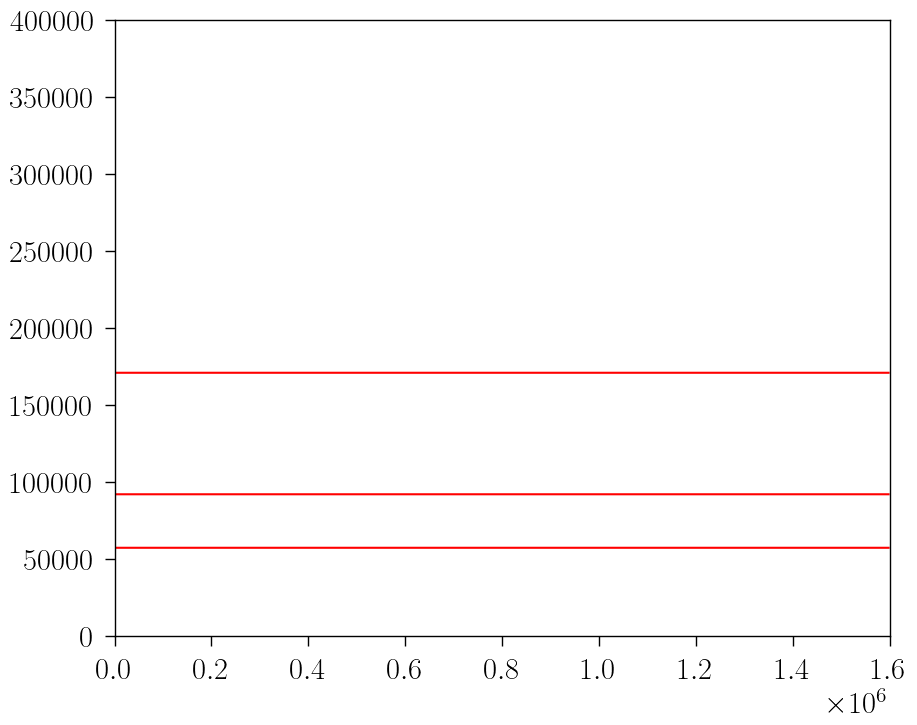

In [ ]:
#Rifting plots
# total model horizontal extent (m)
Lx = 1600 * 1.0e3
# total model vertical extent (m)
Lz = 400 * 1.0e3
# number of points in horizontal direction
Nx = 1601
# number of points in vertical direction
Nz = 401

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)
dz = Lz / (Nz - 1)
Temperi = pd.read_csv( "temperature_0.txt",
                        delimiter=" ",
                        comment="P",
                        skiprows=2,
                        header=None,
    )
Temperi = np.array(Temperi)
Temperi = np.reshape(Temperi, (Nz, Nx))
axs[ax_letter].
# axt.plot(temper_0, -(z_inset)/1000, 'r-', linewidth=1.5, alpha=0.8, zorder=70)
